In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats

In [2]:
data = pd.read_csv('data/runs/n_results.csv', index_col='run')
drug_data = pd.read_csv('full_drug_new.csv')
#drug_data = pd.read_csv('data/runs/drug_data.csv')

# Data cleaning

In [3]:
data = data[data['status']=='completed']
data = data[data['r_2_mean'].notnull()]

data['time'] = pd.to_timedelta(data['time'])
data['started'] = pd.to_datetime(data['started'])
data['seconds'] = data['time'].apply(lambda x:x.seconds)

data['datasets'] = data['gdsc']+data['ctrp']+data['ccle']
data = data[data['datasets']>0]

# The only valid daata
ndata = data[data['started'] > pd.to_datetime('2020-04-15 18:00:00')]

# Joint drug data
drug_data_j = drug_data.join(ndata, rsuffix='_drug', on='run')
drug_data_j = drug_data_j[drug_data_j['started'].notnull()]
ndrug_data = drug_data_j[drug_data_j['started'] > pd.to_datetime('2020-04-15 18:00:00')]
full_data = drug_data.join(data, on='run', rsuffix='_drug')

In [4]:
ndata.describe()

,time,ajive,cutoff,drugs,n,test,threshold,step,r_2_mean,r_2_std,seconds
count,5341,3253.000000,5341.0,5341.000000,5341.000000,0.0,5.341000e+03,5341.0,5341.000000,5340.000000,5341.000000
mean,0 days 00:57:58.619546,2.010144,4.0,19.996443,0.098207,NaN,1.000000e-02,0.0,0.033973,0.344469,3316.852088
std,0 days 01:59:43.764923,0.812848,0.0,0.259981,0.056780,NaN,1.734886e-18,0.0,1.889137,8.390248,5695.418557
min,0 days 00:00:33,1.000000,4.0,1.000000,0.000853,NaN,1.000000e-02,0.0,-136.615707,0.000876,33.000000
25%,0 days 00:09:18,1.000000,4.0,20.000000,0.048426,NaN,1.000000e-02,0.0,-0.031964,0.097725,558.000000
50%,0 days 00:29:49,2.000000,4.0,20.000000,0.097511,NaN,1.000000e-02,0.0,0.086542,0.132590,1789.000000
75%,0 days 01:03:43,3.000000,4.0,20.000000,0.146495,NaN,1.000000e-02,0.0,0.176236,0.204099,3823.000000
max,1 days 17:43:37,3.000000,4.0,20.000000,0.199802,NaN,1.000000e-02,0.0,0.432360,609.875488,82747.000000


# IC/EC quality effect on r2

In [5]:
drugs = drug_data.groupby('Drug').agg({'r2_score': ['mean', 'std']})
drugs['runs'] = [drug_data[drug_data['Drug']==i].shape[0] for i in drugs.index]
one = drugs[drugs['runs']<50].sort_values(by=('r2_score', 'mean'), ascending=False)
multiple = drugs[drugs['runs']>50].sort_values(by=('r2_score', 'mean'), ascending=False)

In [2]:
ctrp = pd.read_csv('data/Processed/ctrp_poz_dr.csv')
gdsc = pd.read_csv('data/Processed/gdsc_poz_dr.csv')
ccle = pd.read_csv('data/Processed/ccle_poz_dr.csv')

In [9]:
pd.concat([ctrp, gdsc, ccle], sort=True)[['AUC_EC50', 'AUC_IC50']].corr()

,AUC_EC50,AUC_IC50
AUC_EC50,1.000000,0.987027
AUC_IC50,0.987027,1.000000


In [7]:
scoring = {'Low':-1, 'Medium':0, 'High':1}
ctrp['IC'] = ctrp['IC50_quality'].replace(scoring)
gdsc['IC'] = gdsc['IC50_quality'].replace(scoring)
gdsc['IC'] = gdsc['IC50_quality'].replace(scoring)

ctrp['EC'] = ctrp['EC50_quality'].replace(scoring)
gdsc['EC'] = gdsc['EC50_quality'].replace(scoring)
gdsc['EC'] = gdsc['EC50_quality'].replace(scoring)

In [8]:
dr = pd.concat([ctrp, gdsc, ccle], sort=True)

In [9]:
c_dict = pd.concat([ctrp, gdsc, ccle], sort=True).groupby('Drug_name').mean()[['IC', 'EC', 'IC50_residual_standard_error', 'EC50_residual_standard_error']]

In [10]:
#c_dict = pd.concat([ctrp, gdsc, ccle], sort=True).groupby('Drug_name').mean()[['IC', 'EC', 'IC50_residual_standard_error', 'EC50_residual_standard_error']]

In [11]:
full = drug_data.join(data, on='run', rsuffix='_drug')
full = full[full['started'] > pd.to_datetime('2020-04-15 18:00:00')]
full['Quality'] = [c_dict.loc[full.loc[i]['Drug']]['IC'] if full.loc[i]['metric_drug']=='AUC_IC50' else c_dict.loc[full.loc[i]['Drug']]['EC'] for i in full.index]
#full['Error'] = [c_dict.loc[full.loc[i]['Drug']]['IC50_residual_standard_error'] if full.loc[i]['metric_drug']=='AUC_IC50' else c_dict.loc[full.loc[i]['Drug']]['EC50_residual_standard_error'] for i in full.index]

In [12]:
full['Quality'] = full['Quality'].fillna(-1)

In [13]:
#full.to_csv('data/runs/full.csv',index=False)

In [14]:
#sns.relplot(x='Error', y='r2_score', data=full[full['r2_score']>-20], kind='scatter', height=9, col='metric_drug', hue='metric_drug', legend=False)

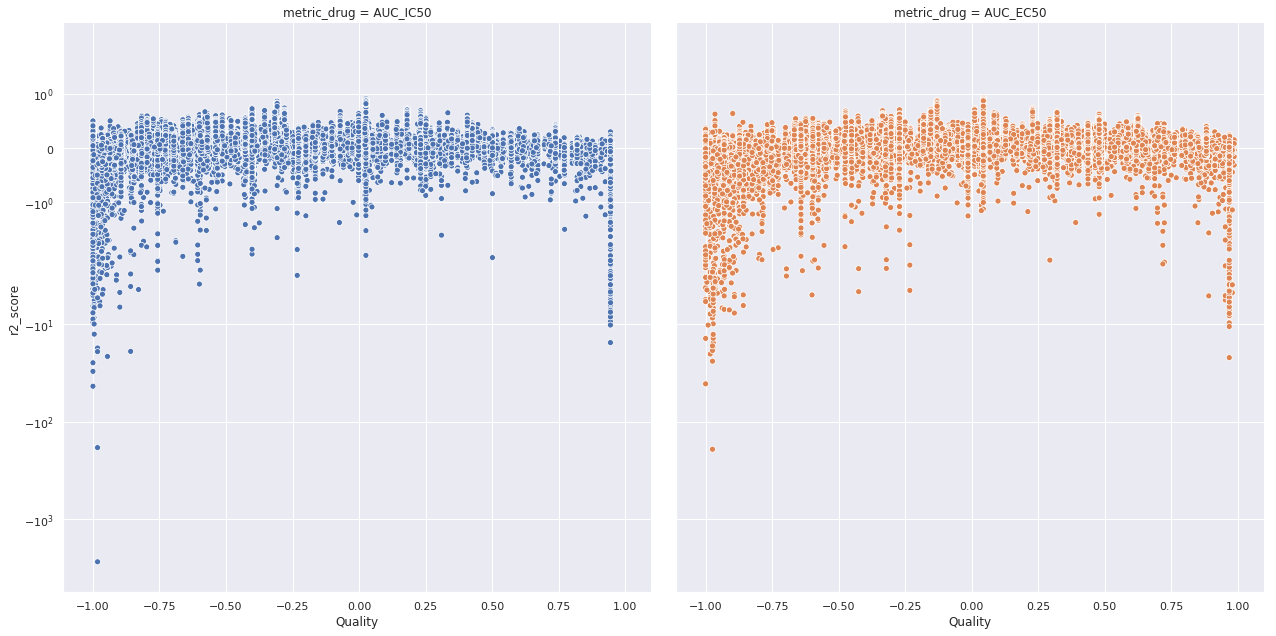

In [15]:
sns.set()
g = sns.relplot(x='Quality', y='r2_score', data=full, kind='scatter', height=9, col='metric_drug', hue='metric_drug', legend=False)
g.set(yscale='symlog')
g.set(ylim=(None, 3))
plt.savefig('IC quality vs r2.png')

In [16]:
drug_ic = full.groupby('Drug').mean()

In [17]:
drug_ic['CCLs'] = [dr[dr['Drug_name']==i].shape[0] for i in drug_ic.index]

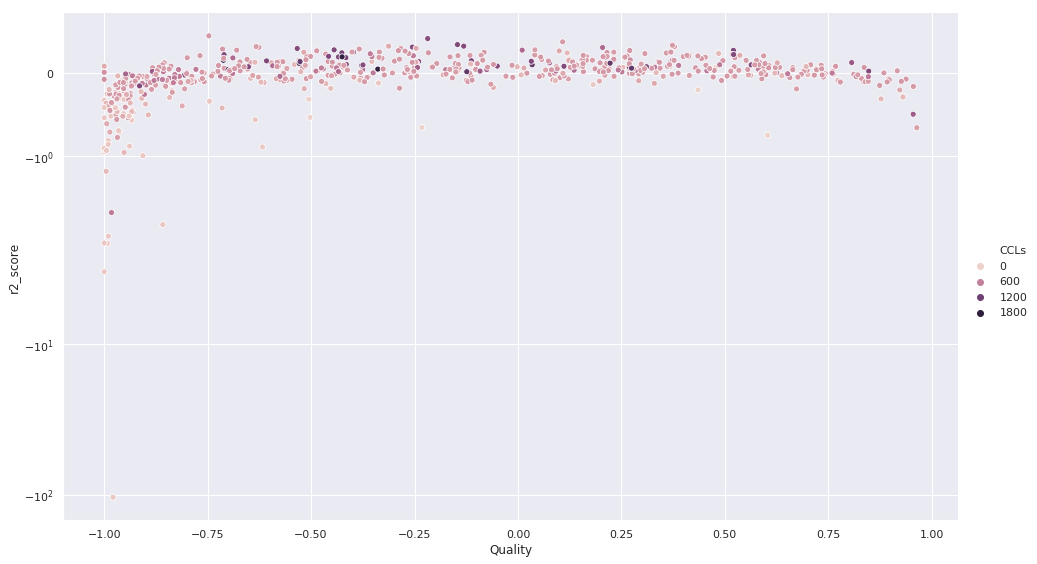

In [18]:
sns.set(font_scale=1)
g = sns.relplot(x='Quality', y='r2_score', data=drug_ic, hue='CCLs', kind='scatter', height=8, aspect=1.7)
g.set(yscale='symlog')
#plt.legend(loc = 'lower right')
#plt.savefig('ICqualitylog.png')

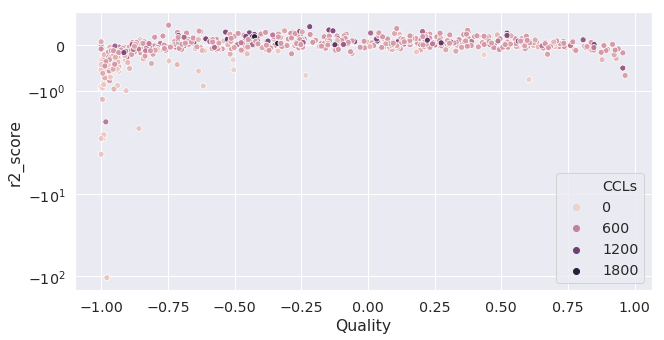

In [19]:
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(1.9*5,5))
g = sns.scatterplot(x='Quality', y='r2_score', data=drug_ic, hue='CCLs', ax=ax, legend='brief')
g.set(yscale='symlog')
plt.legend(loc='lower right')
plt.tight_layout()
#plt.savefig('graphs/ICqualitylog.eps', format='eps')

## A threshold of -0.75 IC quality is set 
All runs below that are disregarded

In [20]:
clean = full[full['Quality']>-0.95]

In [21]:
clean = clean[clean['started'] > pd.to_datetime('2020-04-15 18:00:00')]
clean['norm'] = clean['norm'].fillna('None')
d_r = clean[['Drug', 'r2_score']].groupby('Drug').mean()

In [22]:
clean['r2'] = [clean.loc[i]['r2_score']-d_r.loc[clean.loc[i]['Drug']]['r2_score'] for i in clean.index]

In [46]:
clean['da'] = ['feda' if clean.loc[i]['feda'] else 'ajive' if clean.loc[i]['ajive'] is not None and clean.loc[i]['ajive']>0 else 'none' for i in clean.index]

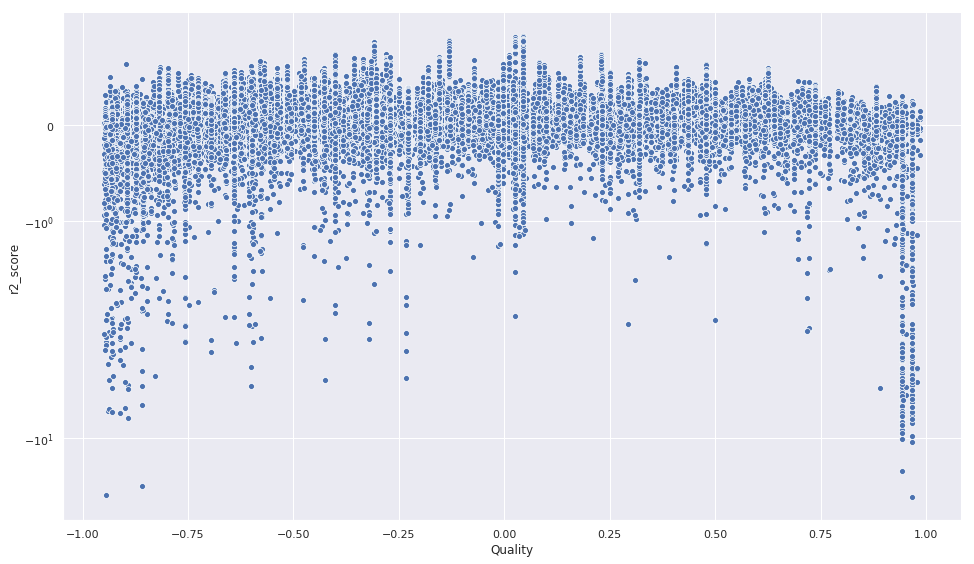

In [25]:
sns.set(font_scale=1)
g = sns.relplot(x='Quality', y='r2_score', data=clean, kind='scatter', height=8, aspect=1.7)
g.set(yscale='symlog')
#plt.legend(loc = 'lower right')
#plt.savefig('Chop.png')

# Measures for overrepresentation on top datasets

In [29]:
def OR(indices, rest, top, group):
    li = []
    for i in indices:
        model_t = top[(top[group[0]]==i[0])&(top[group[1]]==i[1])].shape[0]
        nmodel_t = top[(top[group[0]]!=i[0])|(top[group[1]]!=i[1])].shape[0]
        model_r = rest[(rest[group[0]]==i[0])&(rest[group[1]]==i[1])].shape[0]
        nmodel_r = rest[(rest[group[0]]!=i[0])|(rest[group[1]]!=i[1])].shape[0]
        if model_r > 0 and nmodel_r > 0:
            li.append((model_t/model_r)/(nmodel_t/nmodel_r))
        else:
            li.append(0)
    return li

In [30]:
def top_OR(data, group, q=0.95, score='r2_score'):
    top = data[data[score] >= data[score].quantile(q)]
    counts = data[group +[score]].groupby(group).count()
    topcounts = top[group +[score]].groupby(group).count()
    topcounts['OR'] = OR(topcounts.index, data[data[score]<data[score].quantile(q)], top, group)
    return topcounts